In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# Arguments + Parameters

In [3]:
data_processing_args_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/data_processing_args"

# Batch Queue

In [53]:
mp_args = dict(
    # ----------------------
    # MULTIPROCESSING ARGUMENTS
    # ----------------------
    USE_TORCH=True,
    USE_CUDA=False,
    DTYPE='torch.DoubleTensor',
    NUM_WORKERS=20,
#     NUM_WORKERS=4,
    USE_LOGGING=True,
    LOG_DIR="/om2/user/eisenaj/code/shell_scripts/DeLASE",
    LOG_NAME='mp_delase',
    LOG_LEVEL=logging.DEBUG,
    RESULTS_DIR='/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results',
    
    COMPUTE_IP=False,
    COMPUTE_CHROOTS=False,
    SAVE_JACOBIANS=False,
    TRACK_RESEEDS=False,
    NORM = False,
    NORM_AIC=True,
    
    QUEUE_FULL_SESSION=True,

    # ----------------------
    # DYNAMICAL SYSTEMS ARGUMENTS
    # ----------------------
    parameter_grid=ParameterGrid(
                        window_vals=np.array([15000]),
                        matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1250, 1500]),
                        r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400]),
                    ),
    T_pred=15000, # time steps
    dt = 0.001, # s
#     integrated_performance_kwargs = dict(
#         metrics=['autocorrel_correl', 'fft_correl', 'fft_r2'], 
#         weights='equal',
#         num_lags=500,
#         max_freq=500,
#         fft_n=1000,
#     ),
    integrated_performance_kwargs = {},
    stability_max_freq = 500,
    stability_max_unstable_freq = 125,
    
)

In [89]:
# session_list = [
#     'MrJones-Anesthesia-20160113-01',
#     'Mary-Anesthesia-20160809-01',
#     'MrJones-Anesthesia-20160105-01',
#     'Mary-Anesthesia-20160818-02',
#     'MrJones-Anesthesia-20160121-01',
#     'Mary-Anesthesia-20160831-02',
#     'MrJones-Anesthesia-20160123-01'
# ]

session_list = [
    'Mary-Anesthesia-20160902-02',
    'Mary-Anesthesia-20160908-02',
    'Mary-Anesthesia-20160914-02',
    'Mary-Anesthesia-20160916-02',

    'MrJones-Anesthesia-20160125-01',
    'MrJones-Anesthesia-20160201-01',
    'MrJones-Anesthesia-20160206-01',
    'MrJones-Anesthesia-20160210-01',
    'MrJones-Anesthesia-20160301-01'
]

session_list = os.listdir("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results")

In [90]:
# session_list = session_list[:1]
session_list = session_list[4:]

In [91]:
for session in tqdm(session_list):
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    # -----------------------------------------
    # LOAD DATA AND DIRECTORY
    # -----------------------------------------
    print("loading data...")
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
    section_times = dict( 
            pre=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            during=(eyes_close, session_info['drugEnd'][1]),
            post=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
#     areas = np.unique(electrode_info['area'])
    # areas = np.hstack([areas, 'all'])
    areas = ['all']
    
    print("data loaded!")
    print("loading directory")
    
    chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
    if len(chunked_folder) == 0:
        print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
    else:
        chunked_folder = chunked_folder[0]

    directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))
    
    print("directory loaded!")
    
    # -----------------------------------------
    # PREP AND QUEUE
    # -----------------------------------------
    
    mp_args['RESULTS_DIR'] = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
    
    session_grid_path = os.path.join(mp_args['RESULTS_DIR'], session, 'NORMED' if mp_args['NORM'] else 'NOT_NORMED')
    if len(os.listdir(session_grid_path)) > 0:
        area_example_path = os.path.join(session_grid_path, os.listdir(session_grid_path)[0])
        grid_times = set()
        for f in os.listdir(area_example_path):
            grid_times.add(float(f.split('_')[0]))
        grid_sample_times = list(grid_times)
        grid_sample_times.sort()
    else:
        # PICK GRID SAMPLE TIMES

        sample_nums = {'pre': 4, 'induction': 2, 'during': 4, 'post':2}
        # sample_nums = {'pre': 1, 'induction': 0, 'during': 1, 'post':0}
        margins = 120 # s
        print("Constructing data processing dataframe...")
        grid_sample_times = []
        for section in sections:
            grid_sample_times.extend(np.random.uniform(margins + section_times[section][0], section_times[section][1] - margins, size=(sample_nums[section],)))
        grid_sample_times = np.sort(grid_sample_times)
        grid_sample_times = np.array([int(t*1000)/1000 for t in grid_sample_times])

    data_length = 60 # s, just has to be bigger than window + prediction_time
    data_processing_rows = []
    for area in areas:
        results_dir = os.path.join(mp_args['RESULTS_DIR'], os.path.join(session, 'NORMED' if mp_args['NORM'] else 'NOT_NORMED', area))
        if area == 'all':
            unit_indices = np.arange(len(electrode_info['area']))
        else:
            unit_indices = np.where(electrode_info['area'] == area)[0]
        for t in grid_sample_times:
            finished = True
            for window in mp_args['parameter_grid'].window_vals:
                for matrix_size in mp_args['parameter_grid'].matrix_size_vals:
                    file_path = os.path.join(results_dir, f"{int(t*1000)/1000}_window_{window}_{mp_args['parameter_grid'].expansion_type}_{matrix_size}")
                    if not os.path.exists(file_path):
                        finished = False
                        break
                if not finished:
                    break
            if not finished:
                row = dict(
                    session=session,
                    area=area,
                    window_start=t,
                    window_end=t + data_length,
                    directory=directory,
                    dimension_inds=unit_indices
                )
                data_processing_rows.append(row)
    data_processing_df = pd.DataFrame(data_processing_rows)
    mp_args['data_processing_df'] = data_processing_df
    mp_args['session_list'] = [session]
    mp_args['directories'] = {session: directory}
    data_processing_path = os.path.join(data_processing_args_dir, f"mp_args_{session}_GRID{'_NORMED' if mp_args['NORM'] else ''}.pkl")
    pd.to_pickle(mp_args, data_processing_path)
    print("data processing dataframe constructed!")

    print(f"data processing dataframe has {len(mp_args['data_processing_df'])} rows")

    if not mp_args['USE_CUDA']:
        os.system(f"sbatch --gres=gpu:0 --ntasks=1 --cpus-per-task={int(mp_args['NUM_WORKERS']) + 4} --mem={int(mp_args['NUM_WORKERS']*3)}GB /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")
    else:
        os.system(f"sbatch --gres=gpu:{mp_args['NUM_WORKERS']} /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")


  0%|          | 0/17 [00:00<?, ?it/s]

------------------------------
SESSION = Mary-Anesthesia-20160831-02
------------------------------
loading data...
data loaded!
loading directory
directory loaded!
data processing dataframe constructed!
data processing dataframe has 12 rows
Submitted batch job 30351750
------------------------------
SESSION = Mary-Anesthesia-20160809-01
------------------------------
loading data...
data loaded!
loading directory
directory loaded!
data processing dataframe constructed!
data processing dataframe has 12 rows
Submitted batch job 30351759
------------------------------
SESSION = Mary-Anesthesia-20160818-02
------------------------------
loading data...
data loaded!
loading directory
directory loaded!
data processing dataframe constructed!
data processing dataframe has 12 rows
Submitted batch job 30351782
------------------------------
SESSION = Mary-Anesthesia-20160912-02
------------------------------
loading data...
data loaded!
loading directory
directory loaded!
data processing datafr

In [83]:
os.system("squeue -u eisenaj")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          30337993 millerlab cha-jupy  eisenaj  R   22:19:15      1 node109
          30351280    normal   delase  eisenaj  R       0:09      1 node072


0

In [84]:
os.system('scancel 30351280')

0

# Load Neural Data

In [363]:
# session = 'Mary-Anesthesia-20160912-02'
# session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160826-02'
# session = 'MrJones-Anesthesia-20160107-01'
# session = 'Mary-Anesthesia-20160822-02'


# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160105-01'
# session = 'Mary-Anesthesia-20160818-02'
# session = 'MrJones-Anesthesia-20160121-01'
# session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160123-01'

# ------------
# NOT RUN
# ------------

# session = 'Mary-Anesthesia-20160902-02'
# session = 'Mary-Anesthesia-20160908-02'
# session = 'Mary-Anesthesia-20160914-02'
# session = 'Mary-Anesthesia-20160916-02'

# session = 'MrJones-Anesthesia-20160125-01'
# session = 'MrJones-Anesthesia-20160201-01'
# session = 'MrJones-Anesthesia-20160206-01'
# session = 'MrJones-Anesthesia-20160210-01'
# session = 'MrJones-Anesthesia-20160301-01'

In [364]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [365]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [366]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
# areas = np.hstack([areas, 'all'])

### Load Directory

In [367]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

# MP Args

In [368]:
mp_args = dict(
    # ----------------------
    # MULTIPROCESSING ARGUMENTS
    # ----------------------
    USE_TORCH=True,
    USE_CUDA=False,
    DTYPE='torch.DoubleTensor',
#     NUM_WORKERS=20,
    NUM_WORKERS=4,
    USE_LOGGING=True,
    LOG_DIR="/om2/user/eisenaj/code/shell_scripts/DeLASE",
    LOG_NAME='mp_delase',
    LOG_LEVEL=logging.DEBUG,
    RESULTS_DIR='/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results',
    
    COMPUTE_IP=False,
    COMPUTE_CHROOTS=False,
    TRACK_RESEEDS=False,
    NORM = False,
    NORM_AIC=True,
    
    QUEUE_FULL_SESSION=True,

    # ----------------------
    # DYNAMICAL SYSTEMS ARGUMENTS
    # ----------------------
    parameter_grid=ParameterGrid(
                        window_vals=np.array([15000]),
                        matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1250, 1500]),
                        r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400]),
                    ),
    T_pred=15000, # time steps
    dt = 0.001, # s
#     integrated_performance_kwargs = dict(
#         metrics=['autocorrel_correl', 'fft_correl', 'fft_r2'], 
#         weights='equal',
#         num_lags=500,
#         max_freq=500,
#         fft_n=1000,
#     ),
    integrated_performance_kwargs = {},
    stability_max_freq = 500,
    stability_max_unstable_freq = 125,
    
)

# Grid Search

In [369]:
mp_args['RESULTS_DIR'] = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'

In [370]:
# PICK GRID SAMPLE TIMES

sample_nums = {'pre': 4, 'induction': 2, 'during': 4, 'post':2}
# sample_nums = {'pre': 1, 'induction': 0, 'during': 1, 'post':0}
margins = 120 # s

grid_sample_times = []
for section in sections:
    grid_sample_times.extend(np.random.uniform(margins + section_times[section][0], section_times[section][1] - margins, size=(sample_nums[section],)))
grid_sample_times = np.sort(grid_sample_times)
grid_sample_times = np.array([int(t*1000)/1000 for t in grid_sample_times])

In [371]:
data_length = 60 # s, just has to be bigger than window + prediction_time
data_processing_rows = []
for area in areas:
    results_dir = os.path.join(mp_args['RESULTS_DIR'], os.path.join(session, 'NORMED' if mp_args['NORM'] else 'NOT_NORMED', area))
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    for t in grid_sample_times:
        finished = True
        for window in mp_args['parameter_grid'].window_vals:
            for matrix_size in mp_args['parameter_grid'].matrix_size_vals:
                file_path = os.path.join(results_dir, f"{int(t*1000)/1000}_window_{window}_{mp_args['parameter_grid'].expansion_type}_{matrix_size}")
                if not os.path.exists(file_path):
                    finished = False
                    break
            if not finished:
                break
        if not finished:
            row = dict(
                session=session,
                area=area,
                window_start=t,
                window_end=t + data_length,
                directory=directory,
                dimension_inds=unit_indices
            )
            data_processing_rows.append(row)
data_processing_df = pd.DataFrame(data_processing_rows)
mp_args['data_processing_df'] = data_processing_df
data_processing_path = os.path.join(data_processing_args_dir, f"mp_args_{session}_GRID{'_NORMED' if mp_args['NORM'] else ''}.pkl")
pd.to_pickle(mp_args, data_processing_path)

In [372]:
len(mp_args['data_processing_df'])

48

In [373]:
if not mp_args['USE_CUDA']:
    os.system(f"sbatch --gres=gpu:0 --ntasks=1 --cpus-per-task={int(mp_args['NUM_WORKERS']) + 4} --mem={int(mp_args['NUM_WORKERS']*3)}GB /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")
else:
    os.system(f"sbatch --gres=gpu:{mp_args['NUM_WORKERS']} /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")

Submitted batch job 30176471


In [374]:
os.system("squeue -u eisenaj")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          30170779 millerlab cha-jupy  eisenaj  R    4:05:31      1 node083
          30176471    normal   delase  eisenaj  R       0:01      1 node078
          30176469    normal   delase  eisenaj  R       0:27      1 node070
          30174023    normal   delase  eisenaj  R    1:14:08      1 node110
          30174012    normal   delase  eisenaj  R    1:14:43      1 node116


0

In [826]:
os.system("scancel 30154795")

0

# Load In Results

In [297]:
results_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results"

In [298]:
session_results = {}
# for session in os.listdir(results_dir):

num_its = 0
for session in [session]:
    norm_folder = "NOT_NORMED" if not mp_args['NORM'] else "NORMED"
    for area in os.listdir(os.path.join(results_dir, session, norm_folder)):
        num_its += len(os.listdir(os.path.join(results_dir, session, norm_folder, area)))
iterator = tqdm(total=num_its)

for session in [session]:
    session_results[session] = {}
    norm_folder = "NOT_NORMED" if not mp_args['NORM'] else "NORMED"
    for area in os.listdir(os.path.join(results_dir, session, norm_folder)):
        df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
        for f in os.listdir(os.path.join(results_dir, session, norm_folder, area)):
            t = float(f.split('_')[0])
            file_path = os.path.join(results_dir, session, norm_folder, area, f)
            df_new = pd.DataFrame(pd.read_pickle(file_path))
            if np.isnan(df_new.AIC).sum() > 0:
                print(file_path)
            df_new = df_new.set_index(['window', 'matrix_size', 'r'])
            for i, row in df_new.iterrows():
                if i in df.index:
                    df.loc[i, 'AICs'].append(row.AIC)
                    df.loc[i, 'time_vals'].append(t)
                    df.loc[i, 'file_paths'].append(file_path)
                else:
                    df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}
#                     df.loc[i, 'window'] = int(row.window)
#                     df.loc[i, 'matrix_size'] = int(row.matrix_size)
#                     df.loc[i, 'r'] = int(row.r)
#                     df.window = df.window.astype(int)
#                     df.matrix_size = df.matrix_size.astype(int)
#                     df.r = df.r.astype(int)
            iterator.update()
        df = df.loc[df.index.sortlevel()[0]]
        session_results[session][area] = df

#     window, matrix_size, r = session_results[session].AIC.idxmax()
#     session_results[session] = dict(
#         df=session_results[session],
#         window=window,
#         matrix_size=matrix_size,
#         r=r
#     )
iterator.close()

  0%|          | 0/528 [00:00<?, ?it/s]

In [299]:
# combine_grid_results(session_results[session])
window, matrix_size, r, all_results = combine_grid_results({key: result for key, result in session_results[session].items() if key != 'all'})

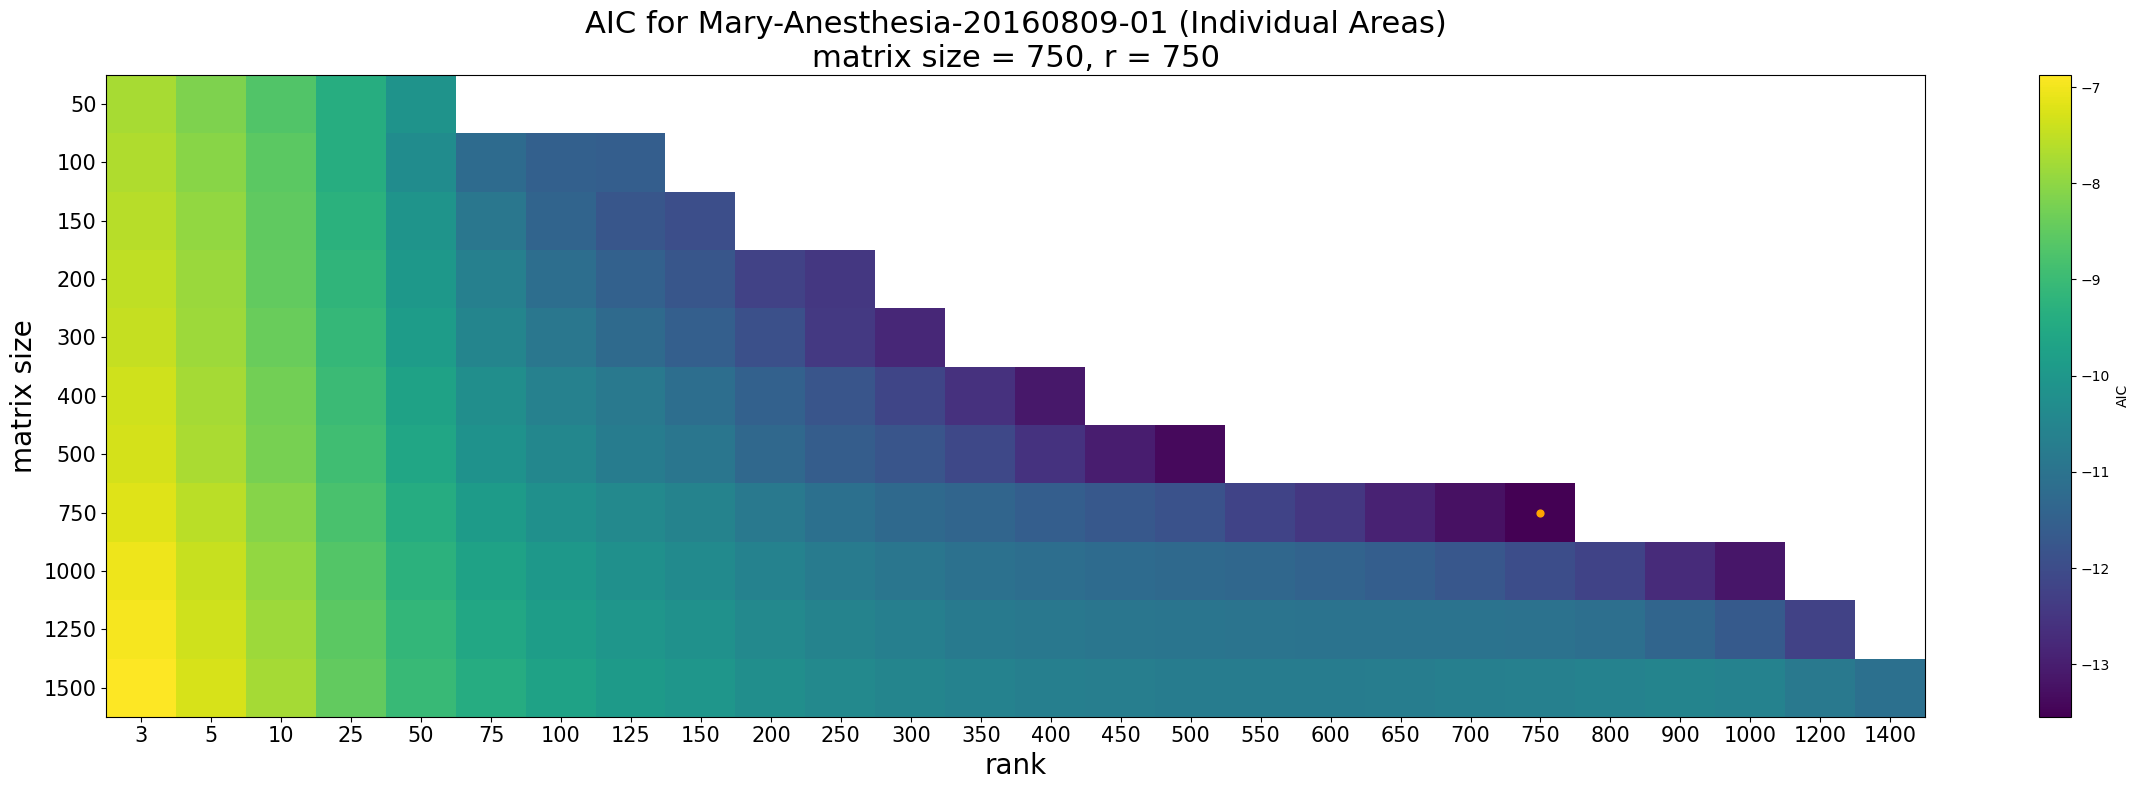

In [300]:
# plot_AIC(session_results[session], title=f"AIC for {session}")
plot_AIC({key: result for key, result in session_results[session].items() if key !='all'}, matrix_size=matrix_size, r=r, title=f"AIC for {session} (Individual Areas)")

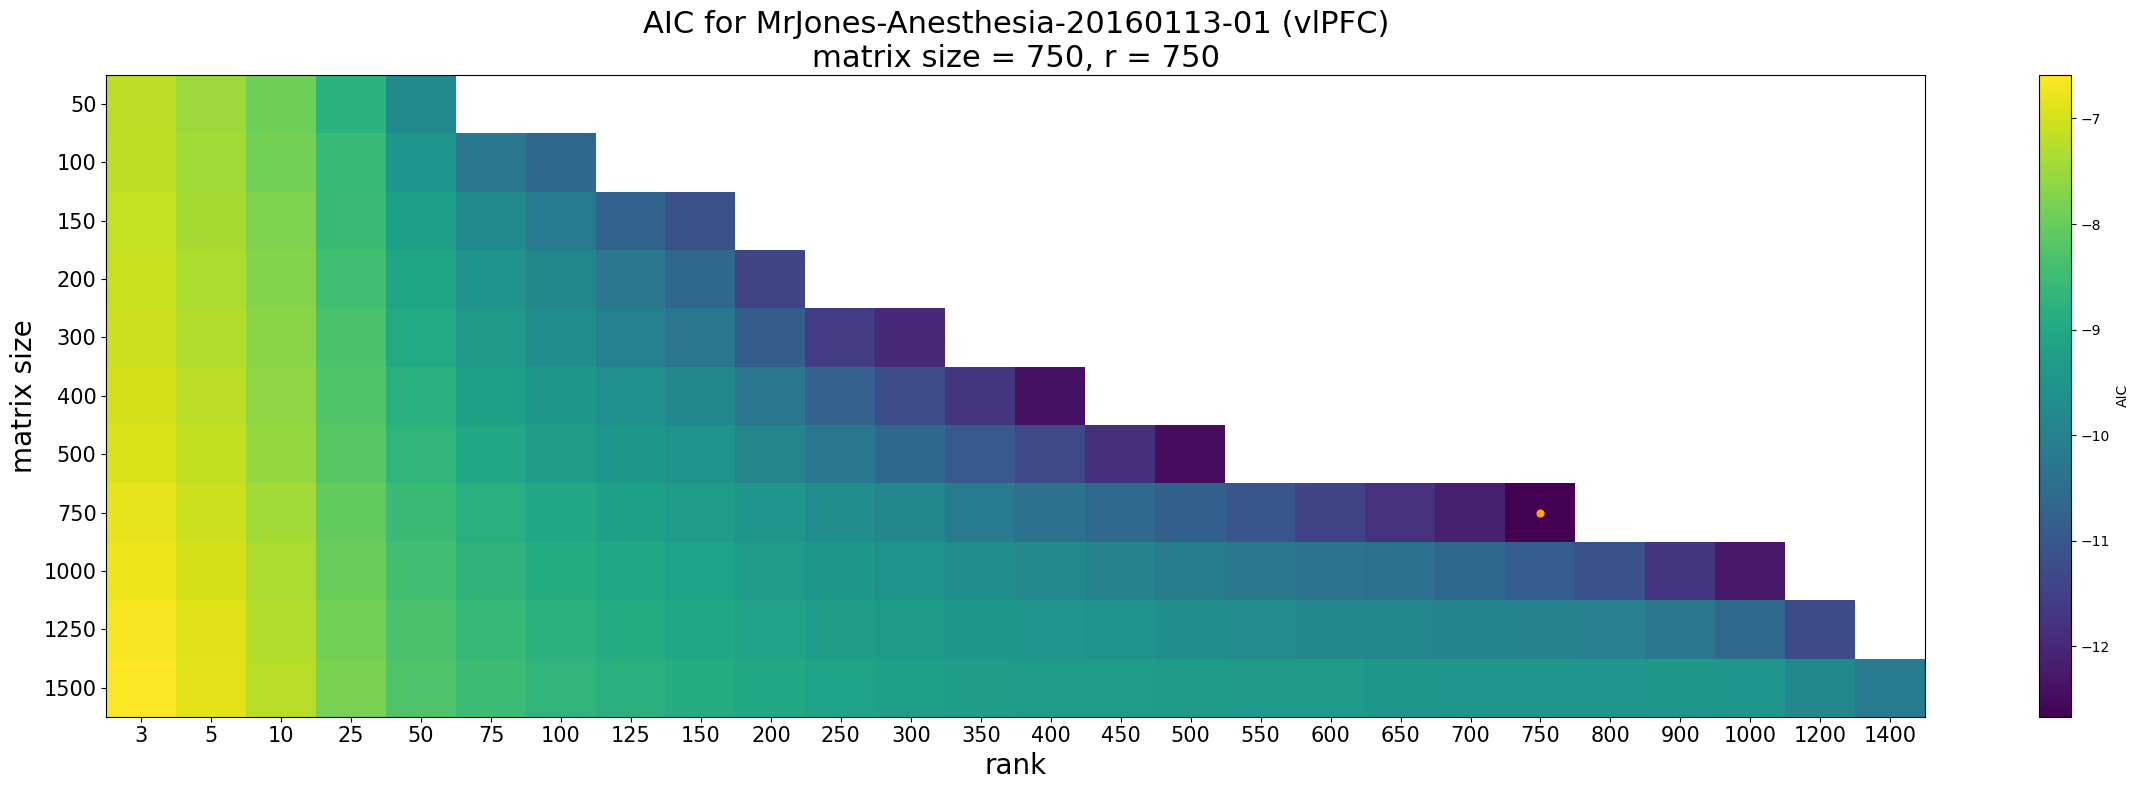

In [281]:
area = 'vlPFC'
plot_AIC({area: session_results[session][area]}, title=f"AIC for {session} ({area})")

In [302]:
# plot_AIC({'all': session_results[session]['all']}, title=f"AIC for {session} (All Areas)")

# Queue the Entire Session

In [303]:
mp_args['RESULTS_DIR'] = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [304]:
mp_args['parameter_grid'] = ParameterGrid(
    window_vals = np.array([window]),
    matrix_size_vals = np.array([matrix_size]),
    r_vals = np.array([r]),
)
mp_args['COMPUTE_CHROOTS'] = True
mp_args['NUM_WORKERS'] = 1
mp_args['QUEUE_FULL_SESSION'] = False

In [305]:
# stride = 60000
stride = window
data_processing_rows = []
for area in areas:
    results_dir = os.path.join(mp_args['RESULTS_DIR'], os.path.join(session, 'NORMED' if mp_args['NORM'] else 'NOT_NORMED', area))
    if area != 'all':
        if area == 'all':
            unit_indices = np.arange(len(electrode_info['area']))
        else:
            unit_indices = np.where(electrode_info['area'] == area)[0]

        t = 0
        while t + window <= len(lfp_schema['index'][0]):
            finished = True
            file_path = os.path.join(results_dir, f"{int(t)/1000}_window_{window}_{mp_args['parameter_grid'].expansion_type}_{matrix_size}")
            if not os.path.exists(file_path):
                row = dict(
                    session=session,
                    area=area,
                    window_start=t*dt,
                    window_end=(t + window + mp_args['T_pred'])*dt,
                    directory=directory,
                    dimension_inds=unit_indices
                )
                data_processing_rows.append(row)
            t += stride
#             if len(data_processing_rows) > 4:
#                 break
data_processing_df = pd.DataFrame(data_processing_rows)
mp_args['data_processing_df'] = data_processing_df
data_processing_path = os.path.join(data_processing_args_dir, f"mp_args_{session}_FULL{'_NORMED' if mp_args['NORM'] else ''}.pkl")
pd.to_pickle(mp_args, data_processing_path)

In [306]:
len(mp_args['data_processing_df'])

1888

In [307]:
mp_args['USE_TORCH'] = False

In [308]:
mp_args['USE_TORCH'], mp_args['NUM_WORKERS']

(False, 1)

In [309]:
mp_args['parameter_grid'].matrix_size_vals, mp_args['parameter_grid'].r_vals

(array([750]), array([750]))

In [310]:
if not mp_args['USE_CUDA']:
    os.system(f"sbatch --gres=gpu:0 --ntasks=1 --cpus-per-task={int(mp_args['NUM_WORKERS']) + 4} --mem={int(mp_args['NUM_WORKERS']*3)}GB /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")
else:
    os.system(f"sbatch --gres=gpu:{mp_args['NUM_WORKERS']} /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")

Submitted batch job 30173993


In [312]:
os.system("squeue -u eisenaj")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          30170779 millerlab cha-jupy  eisenaj  R    2:49:36      1 node083
          30173993    normal   delase  eisenaj  R       0:03      1 node101
          30173962    normal   delase  eisenaj  R       2:15      1 node085


0

In [137]:
os.system('scancel 30171872')

0

# Debugging

In [233]:
data_processing_df[data_processing_df.area == 'vlPFC']

,session,area,window_start,window_end,directory,dimension_inds
881,MrJones-Anesthesia-20160113-01,vlPFC,3015.0,3045.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
882,MrJones-Anesthesia-20160113-01,vlPFC,3030.0,3060.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
883,MrJones-Anesthesia-20160113-01,vlPFC,3045.0,3075.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
884,MrJones-Anesthesia-20160113-01,vlPFC,3060.0,3090.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
885,MrJones-Anesthesia-20160113-01,vlPFC,3075.0,3105.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...,...,...
1373,MrJones-Anesthesia-20160113-01,vlPFC,10395.0,10425.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1374,MrJones-Anesthesia-20160113-01,vlPFC,10410.0,10440.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1375,MrJones-Anesthesia-20160113-01,vlPFC,10425.0,10455.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1376,MrJones-Anesthesia-20160113-01,vlPFC,10440.0,10470.0,start_ind end_ind ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [269]:
row = data_processing_df[np.logical_and(data_processing_df.area == 'FEF', data_processing_df.window_start == 6060.0)].iloc[0]
# row = data_processing_df[np.logical_and(data_processing_df.area == 'vlPFC', data_processing_df.window_start == 3015.0)].iloc[0]

In [242]:
variables = ['lfp']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
lfp = session_vars['lfp']

In [253]:
sig - lfp[int(400/dt):int(430/dt)]

ValueError: operands could not be broadcast together with shapes (30000,252) (30000,232) 

In [215]:
results = {
    'window': [],
    'matrix_size': [],
    'r': [],
    'AIC': [],
    'stability_params': [],
    'stability_freqs': []
}
pd.to_pickle(results, save_path)

In [213]:
save_path = os.path.join(f'/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results/{session}/NOT_NORMED/FEF',"8835.0_window_15000_matrix_size_750")

In [216]:
pd.to_pickle(results, save_path)

In [212]:
len(pd.DataFrame())

0

In [208]:
pd.DataFrame(pd.read_pickle(os.path.join(f'/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results/{session}/NOT_NORMED/7b',"0.0_window_15000_matrix_size_750")))

,window,matrix_size,r,AIC,stability_params,stability_freqs
0,15000,750,750,-11.993817,"[-0.7301215468742229, -2.4027158611188173, -2....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.688..."


In [193]:
T_pred = mp_args['T_pred']
parameter_grid = mp_args['parameter_grid']

In [195]:
window

15000

In [197]:
%%time
delase = DeLASE(signal[:window], dt=dt, matrix_size=matrix_size, use_torch=True, device='cuda')

CPU times: user 2.35 s, sys: 1.61 s, total: 3.96 s
Wall time: 5.32 s


In [222]:
# %%time
# ret = fit_and_test_delase(signal[:window], signal[window:window + T_pred], window, matrix_size, parameter_grid=parameter_grid, dt=dt, norm_aic=True, stability_max_freq=500, stability_max_unstable_freq=125, use_torch=False, device='cpu', dtype='torch.DoubleTensor', verbose=True)

In [223]:
del load_window_from_chunks

In [167]:
9450/60/60

2.625